# Plant Seed V1

## Imports

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
#torch.cuda.set_device

## Data Directory + Create Validation Set 

In [4]:
competition = 'plant-seedlings-classification'

In [5]:
!ls -ltr data/plant-seedlings-classification/

total 320
drwxrwxr-x   796 rv939730  1869323608   27064 Nov 21 11:27 test
-rw-rw-r--     1 rv939730  1869323608   19863 Nov 21 11:37 sample_submission.csv
-rw-r--r--     1 rv939730  1869323608  135381 Nov 24 22:54 labels.csv
drwxrwxr-x  4752 rv939730  1869323608  161568 Nov 24 23:14 train
-rw-r--r--     1 rv939730  1869323608    2890 Nov 25 12:17 sample_labels.csv
drwxr-xr-x     3 rv939730  1869323608     102 Nov 25 12:19 tmp


In [6]:
PATH = "data/"+competition+'/'
sz=224
#arch=resnet50
arch=resnext101_64

bs=28
#bs=58

In [7]:
!ls -ltr $PATH
#!rm -rf $PATH/tmp


total 320
drwxrwxr-x   796 rv939730  1869323608   27064 Nov 21 11:27 test
-rw-rw-r--     1 rv939730  1869323608   19863 Nov 21 11:37 sample_submission.csv
-rw-r--r--     1 rv939730  1869323608  135381 Nov 24 22:54 labels.csv
drwxrwxr-x  4752 rv939730  1869323608  161568 Nov 24 23:14 train
-rw-r--r--     1 rv939730  1869323608    2890 Nov 25 12:17 sample_labels.csv
drwxr-xr-x     3 rv939730  1869323608     102 Nov 25 12:19 tmp


from glob2 import glob
from shutil import move
import os 

df = pd.DataFrame(columns=["file", "species"])

for image in glob(PATH+"train/**/*.png"):
    dir_ = image.split('/')
    file_, species = dir_[-1], dir_[-2]

    df = df.append({
        "file": file_,
        "species": species
        }, ignore_index=True)
    move(PATH+"train/"+species+"/"+file_, PATH+"train/")

df.to_csv(PATH+'labels.csv', index=False)



species = df.pivot_table(index='species', aggfunc=len).sort_values('file', ascending=False)
for sp in species.index: 
    os.rmdir(PATH+'train/'+sp)

sample_train = df.sample(100)
sample_train.to_csv(PATH+'sample_labels.csv', index=False)

In [8]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [245]:
df = pd.read_csv(PATH+'labels.csv')


In [246]:
species = df.pivot_table(index='species', aggfunc=len).sort_values('file', ascending=False)
df = pd.read_csv(PATH+'labels.csv')
df.replace(" ", '_', inplace=True, regex=True)
species_changed = df.pivot_table(index='species', aggfunc=len).sort_values('file', ascending=False)
species.index
df.to_csv(PATH+'labels.edited.csv')
sample_train = df.sample(100)
sample_train.to_csv(PATH+'sample_labels.csv', index=False)
sample_label_csv = f'{PATH}sample_labels.csv'
sample_n = len(list(open(sample_label_csv)))-1
sample_val_idxs = get_cv_idxs(sample_n)

In [247]:
species_dict = {species_changed.index[i]:species.index[i] for i in range(len(species))}

species_dict

{'Black-grass': 'Black-grass',
 'Charlock': 'Charlock',
 'Cleavers': 'Cleavers',
 'Common_Chickweed': 'Common Chickweed',
 'Common_wheat': 'Common wheat',
 'Fat_Hen': 'Fat Hen',
 'Loose_Silky-bent': 'Loose Silky-bent',
 'Maize': 'Maize',
 'Scentless_Mayweed': 'Scentless Mayweed',
 'Shepherds_Purse': 'Shepherds Purse',
 'Small-flowered_Cranesbill': 'Small-flowered Cranesbill',
 'Sugar_beet': 'Sugar beet'}

In [248]:
label_csv

'data/plant-seedlings-classification/labels.csv'

In [249]:
sample_train.head()

,file,species
4288,d394d353a.png,Small-flowered_Cranesbill
1675,94cb20fd9.png,Common_wheat
1041,20a04ea79.png,Common_Chickweed
2379,3cc7097d1.png,Loose_Silky-bent
1896,42912adf2.png,Fat_Hen


In [16]:
??get_cv_idxs

In [17]:
n

4750

In [124]:
sample_val_idxs

array([83, 53, 70, 45, 44, 39, 22, 80, 10,  0, 18, 30, 73, 33, 90,  4, 76, 77, 12, 31])

In [83]:
#val_idxs

In [84]:
len(val_idxs)

950

# Initial Exploration

In [18]:
!ls {PATH}

labels.csv            sample_submission.csv train
sample_labels.csv     test


In [19]:
sample_sub = pd.read_csv(f'{PATH}/sample_submission.csv')

In [20]:
sample_sub.head()

,file,species
0,0021e90e4.png,Sugar beet
1,003d61042.png,Sugar beet
2,007b3da8b.png,Sugar beet
3,0086a6340.png,Sugar beet
4,00c47e980.png,Sugar beet


In [21]:
label_df = pd.read_csv(label_csv)

In [22]:
label_df.head()

label_df.pivot_table(index='species', aggfunc=len).sort_values('file', ascending=False)

,file
species,
Loose Silky-bent,654
Common Chickweed,611
Scentless Mayweed,516
Small-flowered Cranesbill,496
Fat Hen,475
Charlock,390
Sugar beet,385
Cleavers,287
Black-grass,263


# Algorithm 

## Enable Data Augmentation/Filtering

In [25]:
??label_df.pivot_table

In [47]:
??tfms_from_model

In [46]:
??Normalize

In [48]:
??image_gen

In [61]:
??ImageClassifierData

In [25]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH,'train', f'{PATH}/labels.csv', test_name='test', val_idxs=val_idxs, 
                                    tfms=tfms, bs=bs)
#data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4)
#learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [11]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH,'train', f'{PATH}/sample_labels.csv', test_name='test', val_idxs=sample_val_idxs, 
                                    tfms=tfms, bs=bs)
#data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4)
#learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [12]:
data.trn_ds

In [13]:
len(data.trn_ds), len(data.test_ds)

(80, 794)

In [14]:
len(data.classes), data.classes[:5]

(19, ['Black-grass', 'Charlock', 'Chickweed', 'Cleavers', 'Common'])

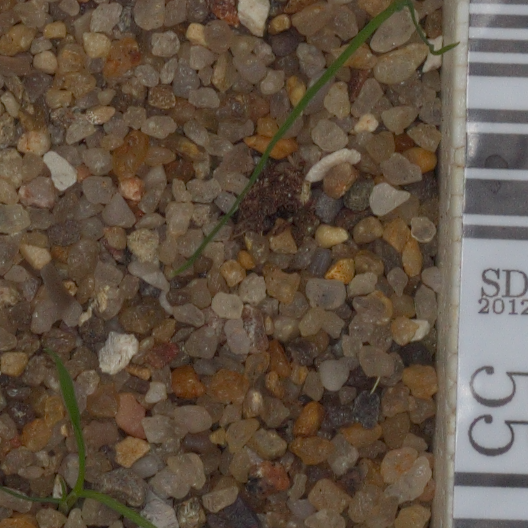

In [15]:
fn = PATH+data.trn_ds.fnames[0]; fn

img = PIL.Image.open(fn); img

In [16]:
img.size

(528, 528)

In [17]:
size_d = {k:PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}

In [18]:
size_d

{'train/0140dfc02.png': (528, 528),
 'train/027f505f5.png': (291, 291),
 'train/05eedce4d.png': (117, 117),
 'train/0dd73ae6a.png': (376, 376),
 'train/138581771.png': (471, 471),
 'train/149f0527e.png': (81, 81),
 'train/15b1ea490.png': (1181, 1181),
 'train/1816ac2d6.png': (169, 169),
 'train/2097eebd0.png': (371, 371),
 'train/2412cb19b.png': (226, 226),
 'train/26103af9c.png': (1440, 1440),
 'train/27a78683b.png': (622, 622),
 'train/299c79409.png': (841, 841),
 'train/2a56e7fec.png': (183, 183),
 'train/2d4fc5fe9.png': (94, 94),
 'train/33253201f.png': (399, 399),
 'train/341823a91.png': (114, 114),
 'train/35e31b2b5.png': (122, 122),
 'train/3a6d4d007.png': (426, 426),
 'train/3a8202693.png': (137, 137),
 'train/49a8c3409.png': (163, 163),
 'train/4dcd59e5b.png': (1434, 1434),
 'train/4e34f35c1.png': (187, 187),
 'train/523c4c9dd.png': (250, 250),
 'train/5926abc69.png': (168, 168),
 'train/5ca0fcfba.png': (752, 752),
 'train/6090033e9.png': (697, 697),
 'train/61a79f4a1.png': (1

In [19]:
row_sz, col_sz = zip(*size_d.values())

In [35]:
row_sz=np.array(row_sz); col_sz= np.array(col_sz)

In [36]:
row_sz[:5]

array([528, 291, 117, 376, 471])

(array([ 47.,  23.,   6.,   3.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([   67. ,   459.4,   851.8,  1244.2,  1636.6,  2029. ,  2421.4,  2813.8,  3206.2,  3598.6,  3991. ]),
 <a list of 10 Patch objects>)

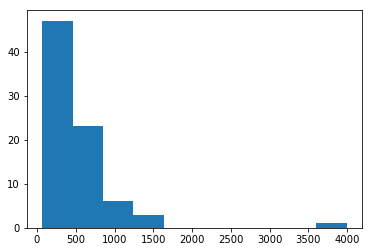

In [37]:
plt.hist(row_sz)

In [38]:
len(row_sz[row_sz<500])

51

(array([ 15.,  15.,   7.,   7.,   9.,   3.,   7.,   5.,   3.,   3.]),
 array([  67. ,  157.8,  248.6,  339.4,  430.2,  521. ,  611.8,  702.6,  793.4,  884.2,  975. ]),
 <a list of 10 Patch objects>)

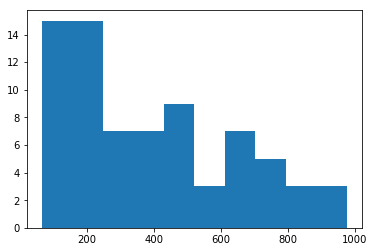

In [39]:
plt.hist(row_sz[row_sz<1000])

(array([ 47.,  23.,   6.,   3.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([   67. ,   459.4,   851.8,  1244.2,  1636.6,  2029. ,  2421.4,  2813.8,  3206.2,  3598.6,  3991. ]),
 <a list of 10 Patch objects>)

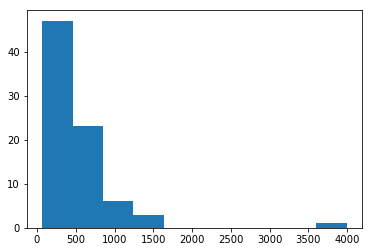

In [40]:
plt.hist(row_sz)

(array([ 42.,  24.,   8.,   3.,   2.,   0.,   0.,   0.,   0.,   1.]),
 array([   67.,   406.,   745.,  1084.,  1423.,  1762.,  2101.,  2440.,  2779.,  3118.,  3457.]),
 <a list of 10 Patch objects>)

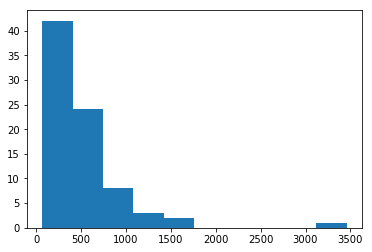

In [41]:
plt.hist(col_sz)

In [42]:
len(col_sz[col_sz<500])

51

(array([ 15.,  15.,   7.,   7.,   9.,   3.,   7.,   5.,   3.,   3.]),
 array([  67. ,  157.8,  248.6,  339.4,  430.2,  521. ,  611.8,  702.6,  793.4,  884.2,  975. ]),
 <a list of 10 Patch objects>)

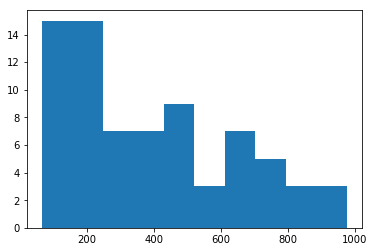

In [43]:
plt.hist(col_sz[col_sz<1000])

In [44]:
len(row_sz[row_sz<500])

51

(array([ 15.,  15.,   7.,   7.,   9.,   3.,   7.,   5.,   3.,   3.]),
 array([  67. ,  157.8,  248.6,  339.4,  430.2,  521. ,  611.8,  702.6,  793.4,  884.2,  975. ]),
 <a list of 10 Patch objects>)

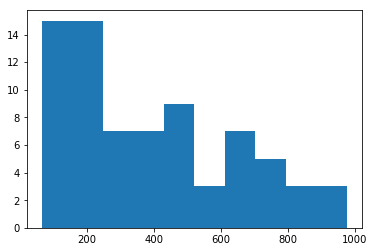

In [45]:
plt.hist(row_sz[row_sz<1000])

## Initial Model 

In [149]:
def get_data(sz,bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH,'train', f'{PATH}/labels.csv', test_name='test', val_idxs=val_idxs,
                                    tfms=tfms, bs=bs)
    return data if sz>300  else data.resize(340,'tmp')
#data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4)
#learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [254]:
def sample_get_data(sz,bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH,'train', f'{PATH}/sample_labels.csv', test_name='test', val_idxs=sample_val_idxs,
                                    tfms=tfms, bs=bs)
    return data if sz>500  else data.resize(540,'tmp')
#data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4)
#learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [196]:
??parse_csv_labels

In [193]:
??ImageClassifierData

### Precompute

In [163]:
??data.resized

In [255]:
data = sample_get_data(sz,bs)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [257]:
data.classes

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common_Chickweed',
 'Common_wheat',
 'Fat_Hen',
 'Loose_Silky-bent',
 'Maize',
 'Scentless_Mayweed',
 'Shepherds_Purse',
 'Small-flowered_Cranesbill',
 'Sugar_beet']

In [258]:
??validate

In [261]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(1e-2,1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       3.0043   2.73358  0.05   ]                   



In [262]:
accuracy

<function fastai.metrics.accuracy>

In [263]:
learn.precompute=False

In [264]:
learn.fit(1e-2, 5, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

KeyboardInterrupt: 

In [15]:
learn.unfreeze()
lr=np.array([1e-4,1e-3,1e-2])

In [17]:
learn.fit(lr, 3, cycle_len=1)

A Jupyter Widget

[ 0.       0.03577  0.01557  0.99504]                         
[ 1.       0.03684  0.01287  0.99554]                         
[ 2.       0.02823  0.01572  0.99653]                         



In [23]:
learn.save('224_all_50')

In [115]:
learn.load('224_all_50')

In [165]:
fn = data.test_ds.fnames
fn

['test/0021e90e4.png',
 'test/003d61042.png',
 'test/007b3da8b.png',
 'test/0086a6340.png',
 'test/00c47e980.png',
 'test/00d090cde.png',
 'test/00ef713a8.png',
 'test/01291174f.png',
 'test/026716f9b.png',
 'test/02cfeb38d.png',
 'test/03566743d.png',
 'test/03a2ee656.png',
 'test/03e322a29.png',
 'test/03ef36742.png',
 'test/043449b0b.png',
 'test/0437393b1.png',
 'test/04814f36d.png',
 'test/05341a8a6.png',
 'test/060450d79.png',
 'test/060f1dc84.png',
 'test/0625f063b.png',
 'test/063363305.png',
 'test/06d12f6fa.png',
 'test/071cb3ece.png',
 'test/0751c0bbc.png',
 'test/07e62f903.png',
 'test/085974290.png',
 'test/0885e7690.png',
 'test/089ad62a7.png',
 'test/08d591441.png',
 'test/0911d3dee.png',
 'test/099b961ec.png',
 'test/0a64e3e6c.png',
 'test/0ad9e7dfb.png',
 'test/0ae6668fa.png',
 'test/0bf7bfb05.png',
 'test/0c27cf05f.png',
 'test/0c4199daa.png',
 'test/0c45ace27.png',
 'test/0c51bf229.png',
 'test/0c5f6c493.png',
 'test/0caeda5df.png',
 'test/0d117d910.png',
 'test/0d31

In [156]:
trn_tfms, val_tfms = tfms_from_model(arch,sz)

In [157]:
PATH+fn[0]

'data/plant-seedlings-classification/test/0021e90e4.png'

In [158]:
np.array(Image.open(PATH+fn[0])).shape

(270, 270, 3)

In [166]:
im = trn_tfms(np.array(Image.open(PATH+fn[100])))

In [167]:
im.shape

(3, 224, 224)

In [179]:
species = df.pivot_table(index='species', aggfunc=len).sort_values('file', ascending=False)
species.index

Index(['Loose Silky-bent', 'Common Chickweed', 'Scentless Mayweed',
       'Small-flowered Cranesbill', 'Fat Hen', 'Charlock', 'Sugar beet',
       'Cleavers', 'Black-grass', 'Shepherds Purse', 'Common wheat', 'Maize'],
      dtype='object', name='species')

In [176]:
im[None].shape
preds = to_np(learn.models.model(V(T(im[None]))))
np.argmax(preds)

16

In [152]:
preds

array([[ 0.36629,  0.55008,  0.4488 ,  0.77265,  0.2461 ,  0.3616 ,  0.63546,  0.63927,  0.57553,  0.47081,
         0.71923,  0.48134,  0.49388,  0.51775,  0.68656,  0.5676 ,  0.73902,  0.418  ,  0.49291]], dtype=float32)

In [182]:
log_preds,y = learn.TTA()
#accuracy(log_preds,y)

In [183]:
log_test_preds = learn.TTA(is_test=True)
#accuracy(log_test_preds,test_y)

In [184]:
len(log_test_preds[1])

794

In [185]:
log_test_preds[0]

array([[ 0.40841,  0.65501,  0.67015, ...,  0.49974,  0.53267,  0.48693],
       [ 0.30132,  0.69162,  0.53501, ...,  0.5701 ,  0.42573,  0.53474],
       [ 0.34956,  0.72251,  0.48156, ...,  0.50856,  0.56137,  0.49215],
       ..., 
       [ 0.30393,  0.55386,  0.50309, ...,  0.62428,  0.46421,  0.5346 ],
       [ 0.36159,  0.45509,  0.41066, ...,  0.60553,  0.6099 ,  0.47587],
       [ 0.25312,  0.55853,  0.58617, ...,  0.62451,  0.37578,  0.34508]], dtype=float32)

In [186]:
test_probs = np.exp(log_test_preds[0])


In [187]:
test = np.argmax(np.exp(log_test_preds[0]))

In [188]:
test

6181

In [189]:
out_df_1 = pd.DataFrame(data = test_probs, columns=learn.data.classes)

out_df_1.head()

,Black-grass,Charlock,Chickweed,Cleavers,Common,Cranesbill,Fat,Hen,Loose,Maize,Mayweed,Purse,Scentless,Shepherds,Silky-bent,Small-flowered,Sugar,beet,wheat
0,1.504426,1.925158,1.954523,1.805856,1.435221,1.587120,2.100815,1.784615,1.668774,1.585874,1.894262,1.645990,1.637046,1.482631,1.862962,1.811631,1.648284,1.703472,1.627320
1,1.351643,1.996955,1.707458,1.702403,1.442814,1.673813,1.968851,1.635464,1.571304,1.558804,1.789822,1.545016,1.640467,1.543754,1.808143,1.766900,1.768445,1.530714,1.707013
2,1.418446,2.059592,1.618598,1.806492,1.443993,1.620877,1.863143,1.751896,1.736272,1.630557,1.743867,1.667488,1.859946,1.647101,1.912166,1.792270,1.662895,1.753070,1.635823
3,1.332318,1.896837,1.768145,1.836633,1.679963,1.705938,1.810837,1.757485,1.699767,1.541472,1.771831,1.535244,1.742975,1.556746,1.894557,1.864321,1.881272,1.711249,1.759404
4,1.428694,1.838775,1.745739,1.746516,1.402598,1.612312,2.002947,1.884888,1.765942,1.637733,1.704852,1.680324,1.774195,1.555682,1.767060,1.747331,1.699948,1.613276,1.570884


In [200]:
type(test_probs)

numpy.ndarray

In [194]:
len(data.test_dl.dataset.fnames)

10357

In [205]:
learn.

In [225]:
t = "test/000621fb3cbb32d8935728e48679680e.jpg"
re.match(r".*/(.*)\..*",t)[1]

'000621fb3cbb32d8935728e48679680e'

In [226]:
ids = [re.match(r".*/(.*)\..*",id)[1] for id in data.test_dl.dataset.fnames]

In [201]:
type(data.test_dl.dataset.fnames)

list

In [228]:
out_df = pd.DataFrame({'id':ids})

out_df.head()

In [234]:
result = pd.concat([out_df,out_df_1], axis=1, join_axes=[out_df.index])


result.head()

In [242]:
result.to_csv('dog_breeder_test_submit.1.csv',index=False)


In [243]:
test = pd.read_csv('dog_breeder_test_submit.1.csv')

test.head()

In [211]:
learn.data.classes

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',


In [150]:
learn.summary()

AssertionError: Torch not compiled with CUDA enabled

## Analyzing results

In [117]:
preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds[:,1])

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [133]:
test_preds = np.argmax(log_test_preds, axis=1)
test_probs = np.exp(log_test_preds[:,1])

#from sklearn.metrics import confusion_matrix
#cm = confusion_matrix(y, preds)


In [139]:
test_probs.shape

(10357,)

In [ ]:
test_labels = []
for i in range(len(test_x)):
    
    test_batch = Variable(test_x[i].unsqueeze_(0))
    
    output = model(test_batch)
    _, output = torch.max(output, dim = 1)
    
    test_labels.append(int(output.data.numpy()))

np.savetxt("foo.csv", test_labels, delimiter=",")

In [134]:
len(test_probs)

10357

[[16  0  0 ...,  0  0  0]
 [ 0 24  0 ...,  0  0  0]
 [ 0  0 15 ...,  0  0  0]
 ..., 
 [ 0  0  0 ..., 15  0  0]
 [ 0  0  0 ...,  0 22  0]
 [ 0  0  0 ...,  0  0 15]]


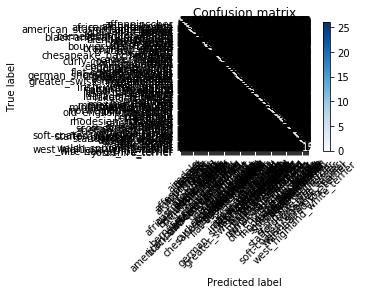

In [118]:
plot_confusion_matrix(cm, data.classes)

In [119]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

Most incorrect cats


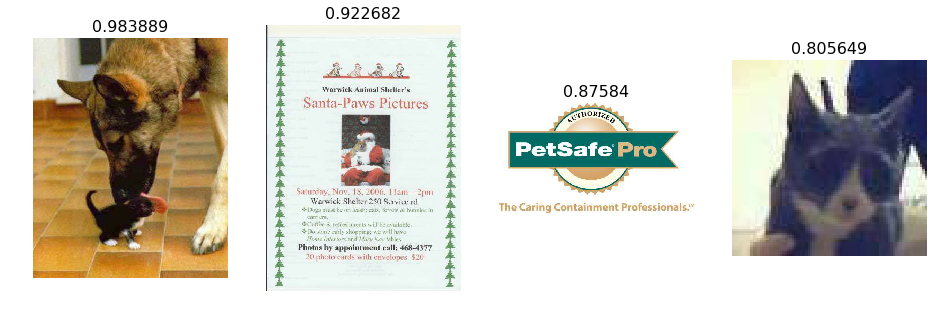

In [28]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


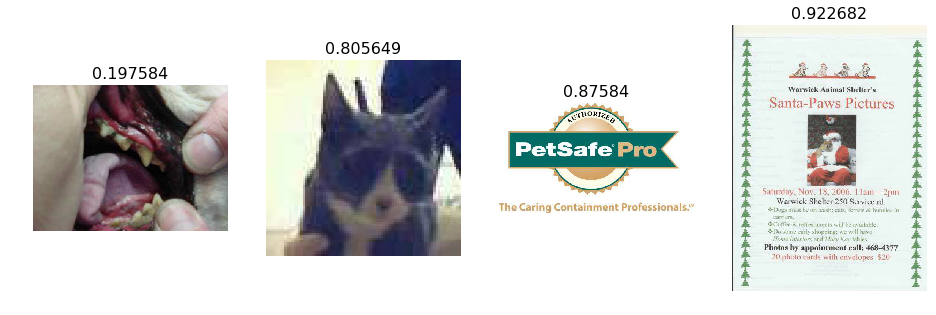

In [29]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")